# Tutorial for a `NODE` Classifier 

- the train data size is `GB` scale. Beware when downloading the trainset. 

In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=0,1
import os, sys
import time
sys.path.insert(0, '..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import lib_node_hong_v1 as lib
import torch, torch.nn as nn
import torch.nn.functional as F
from qhoptim.pyt import QHAdam

env: CUDA_VISIBLE_DEVICES=0,1


#### This download should work, but .. 

In [2]:
%%time
# read the data
data = lib.Dataset("EPSILON", random_state=1337, quantile_transform=True, quantile_noise=1e-3)

reading dataset (it may take a long time)
CPU times: user 6min 41s, sys: 10.9 s, total: 6min 51s
Wall time: 6min 51s


#### Alternative Download Scripts by ChatGPT

> Done the download anyway! 

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")
print(f"Using {torch.cuda.device_count()} GPUs!")
print(f"Torch Version: {torch.__version__} ")

Using cuda device
Using 2 GPUs!
Torch Version: 2.2.0+cu121 


> __Note:__ make sure you're using torch version `>= 1.1.0`, the code will silently fail even on 1.0.1.

In [12]:
# I will use the second gpu card, `cuda:1'
device = 'cuda:1'

In [13]:
experiment_name = 'epsilon_node_2layers'
experiment_name = '{}_{}.{:0>2d}.{:0>2d}_{:0>2d}:{:0>2d}'.format(experiment_name, *time.gmtime()[:5])
print("experiment:", experiment_name)

experiment: epsilon_node_2layers_2024.08.02_06:35


## Quick EDA of trainset

In [14]:
num_features = data.X_train.shape[1]
num_classes = len(set(data.y_train))

In [15]:
num_features,num_classes

(2000, 2)

In [16]:
data.X_train.shape,data.y_train.shape,data.X_train.dtype,data.y_train.dtype

((320000, 2000), (320000,), dtype('float32'), dtype('int32'))

In [17]:
data.X_train[0], len(data.X_train[0])

(array([-0.15426391,  0.1682854 , -0.43472594, ..., -0.08909157,
        -0.24744773, -0.43901673], dtype=float32),
 2000)

In [18]:
# basic stats of features
mins = np.min(data.X_train, axis=0)
maxs = np.max(data.X_train, axis=0)
means = np.mean(data.X_train, axis=0)
stds = np.std(data.X_train, axis=0)

print("Min :", mins[:5])
print("Max :", maxs[:5])
print("Mean :", means[:5])
print("Standard deviations :", stds[:5])

Min : [-2.0870929 -1.9660672 -1.9407631 -2.146792  -1.5116274]
Max : [2.2225301 1.8621529 2.10931   2.208831  1.1429169]
Mean : [ 0.01122015  0.02413633 -0.00786853  0.00565979  0.01249396]
Standard deviations : [0.4077688  0.40246457 0.39186302 0.40282065 0.4105482 ]


In [19]:
np.unique(data.y_train)

array([0, 1], dtype=int32)

## Set model and Fit

In [20]:
from torch.nn.parallel import DistributedDataParallel as DDP

In [21]:
model = nn.Sequential(
    lib.DenseBlock(num_features, layer_dim=1024, num_layers=2, tree_dim=num_classes + 1, flatten_output=False,
                   depth=6, choice_function=lib.entmax15, bin_function=lib.entmoid15),
    lib.Lambda(lambda x: x[..., :num_classes].mean(dim=-2)),
).to(device)

with torch.no_grad():
    res = model(torch.as_tensor(data.X_train[:2000], device=device))
    # trigger data-aware init


#if torch.cuda.device_count() > 1:
    #model = DDP(model)
    ### deadlock#### 
    #model = model.to('cuda')
    #model = nn.DataParallel(model)

In [22]:
trainer = lib.Trainer(
    model=model, loss_function=F.cross_entropy,
    experiment_name=experiment_name,
    warm_start=False,
    Optimizer=QHAdam,
    optimizer_params=dict(nus=(0.7, 1.0), betas=(0.95, 0.998)),
    verbose=True,
    n_last_checkpoints=5
)

In [23]:
from tqdm import tqdm
from IPython.display import clear_output
loss_history, err_history = [], []
best_val_err = 1.0
best_step = 0
early_stopping_rounds = 1000
report_frequency = 100

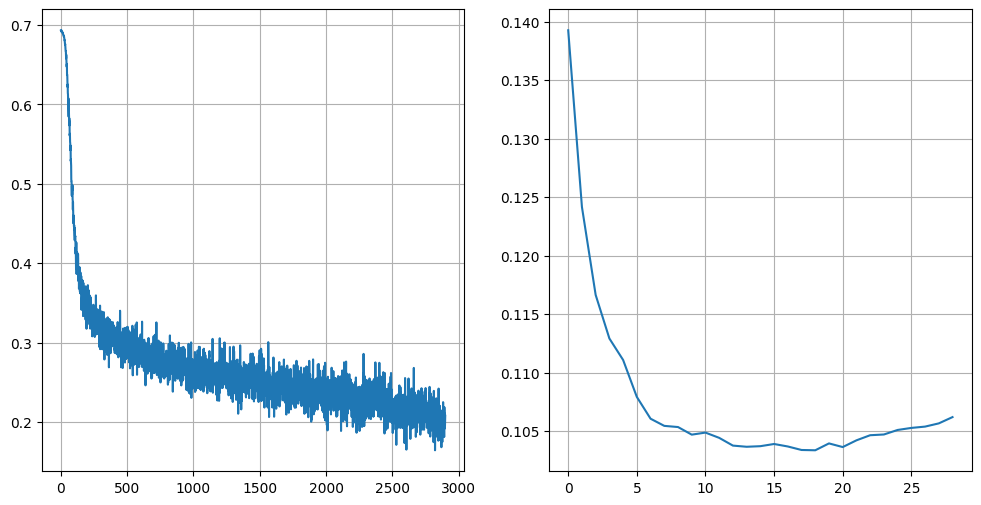

Loss 0.20787
Val Error Rate: 0.10619
BREAK. There is no improvment for 1000 steps
Best step:  1900
Best Val Error Rate: 0.10335
CPU times: user 9min 37s, sys: 2min 37s, total: 12min 14s
Wall time: 12min 14s


In [24]:
%%time
for batch in lib.iterate_minibatches(data.X_train, data.y_train, 
                                     batch_size=1024, shuffle=True, \
                                     epochs=10,verbose=True):
    metrics = trainer.train_on_batch(*batch, device=device)
    
    loss_history.append(metrics['loss'])

    if trainer.step % report_frequency == 0:
        trainer.save_checkpoint()
        trainer.average_checkpoints(out_tag='avg')
        trainer.load_checkpoint(tag='avg')
        err = trainer.evaluate_classification_error(
            data.X_valid, data.y_valid, device=device, batch_size=1024)
        
        if err < best_val_err:
            best_val_err = err
            best_step = trainer.step
            trainer.save_checkpoint(tag='best')
        
        err_history.append(err)
        trainer.load_checkpoint()  # last
        trainer.remove_old_temp_checkpoints()
            
        clear_output(True)
        plt.figure(figsize=[12, 6])
        plt.subplot(1, 2, 1)
        plt.plot(loss_history)
        plt.grid()
        plt.subplot(1,2,2)
        plt.plot(err_history)
        plt.grid()
        plt.show()
        print("Loss %.5f" % (metrics['loss']))
        print("Val Error Rate: %0.5f" % (err))
        
    if trainer.step > best_step + early_stopping_rounds:
        print('BREAK. There is no improvment for {} steps'.format(early_stopping_rounds))
        print("Best step: ", best_step)
        print("Best Val Error Rate: %0.5f" % (best_val_err))
        break

In [58]:
trainer.load_checkpoint() # latest one
trainer.load_checkpoint(tag='best') # best one
error_rate = trainer.evaluate_classification_error(data.X_test, data.y_test, device=device, batch_size=1024)
print('Best step: ', trainer.step)
print("Test Error rate: %0.5f" % (error_rate))

Loaded logs/epsilon_node_2layers_2024.08.02_06:35/checkpoint_temp_2900.pth
Loaded logs/epsilon_node_2layers_2024.08.02_06:35/checkpoint_best.pth
Best step:  1900
Test Error rate: 0.10361


In [59]:
print(trainer)

Trainer(
  (model): Sequential(
    (0): DenseBlock(
      (0): ODST(in_features=2000, num_trees=1024, depth=6, tree_dim=3, flatten_output=True)
      (1): ODST(in_features=5072, num_trees=1024, depth=6, tree_dim=3, flatten_output=True)
    )
    (1): Lambda()
  )
)


#### Inferences

In [60]:
X_test = torch.as_tensor(data.X_test, device=device)

In [62]:
X_test.shape, X_test[0]

(torch.Size([100000, 2000]),
 tensor([ 0.1586,  0.1558, -0.0224,  ...,  0.0544,  0.5582, -0.2537],
        device='cuda:1'))

In [65]:
F.softmax(model(X_test[:5]),dim=1)

tensor([[0.8813, 0.1187],
        [0.1054, 0.8946],
        [0.0952, 0.9048],
        [0.9567, 0.0433],
        [0.2887, 0.7113]], device='cuda:1', grad_fn=<SoftmaxBackward0>)

In [63]:
torch.argmax(F.softmax(model(X_test[:5]), dim=1), dim=1)

tensor([0, 1, 1, 0, 1], device='cuda:1')

In [64]:
torch.argmax(F.softmax(model(X_test[:5]), dim=1), dim=1).cpu().numpy()

array([0, 1, 1, 0, 1])